2024-04-13 16:21:56,855 - MAB Application - INFO - EpsilonGreedy Total Reward: 15331.0
2024-04-13 16:21:56,856 - MAB Application - INFO - EpsilonGreedy Average Reward: 0.42941791849799504
2024-04-13 16:21:56,856 - MAB Application - INFO - Results written to /var/folders/9b/rd0xfyt94zxfz9skqgpl_tm00000gn/T/EpsilonGreedy_results.csv
2024-04-13 16:21:56,856 - MAB Application - INFO - ThompsonSampling Total Reward: 16023.0
2024-04-13 16:21:56,857 - MAB Application - INFO - ThompsonSampling Average Reward: 0.38381660657051286
2024-04-13 16:21:56,857 - MAB Application - INFO - Results written to /var/folders/9b/rd0xfyt94zxfz9skqgpl_tm00000gn/T/ThompsonSampling_results.csv


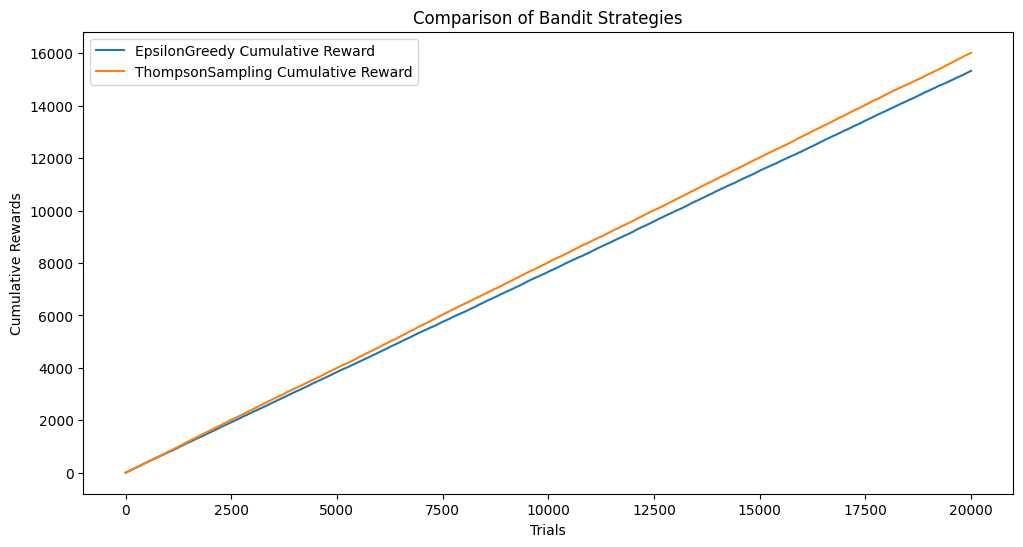

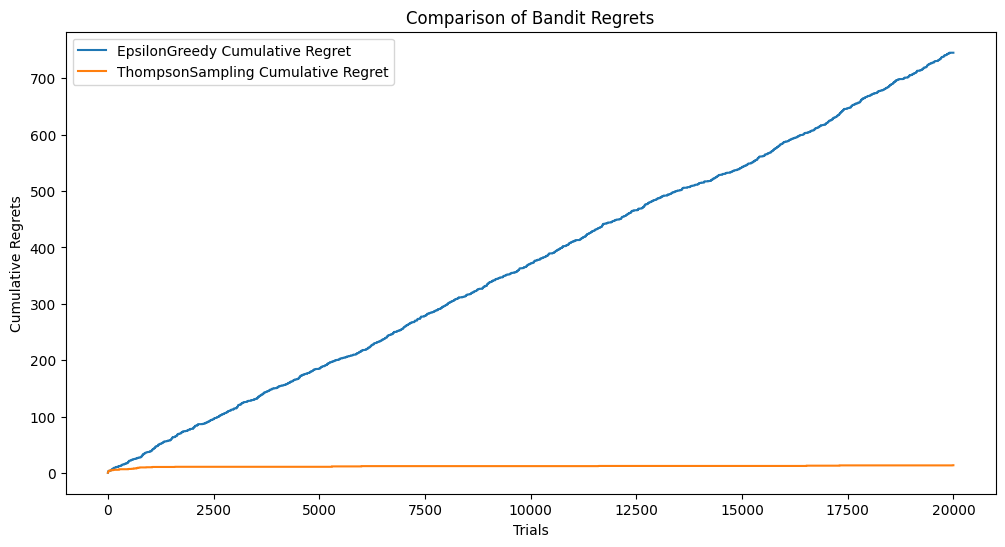

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import logging
import tempfile
from abc import ABC, abstractmethod

# Configure Logger
logger = logging.getLogger('MAB Application')
logger.setLevel(logging.DEBUG)

# Clear existing handlers to prevent duplicate logging
logger.handlers = []

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('\033[1;37m%(asctime)s - %(name)s - %(levelname)s - \033[0m%(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

class Bandit(ABC):
    def __init__(self, probabilities):
        self.probabilities = probabilities
        self.rewards = np.zeros(len(probabilities))
        self.attempts = np.zeros(len(probabilities))
        self.total_rewards = []
        self.total_regrets = []

    @abstractmethod
    def pull(self):
        pass

    def update(self, arm, reward):
        self.attempts[arm] += 1
        self.rewards[arm] += reward
        self.total_rewards.append(reward)
        self.total_regrets.append(np.max(self.probabilities) - self.probabilities[arm])

    def experiment(self, n_trials):
        for _ in range(n_trials):
            arm = self.pull()
            reward = np.random.rand() < self.probabilities[arm]
            self.update(arm, reward)

    def report(self, algorithm_name):
        # Use a temporary file for the results
        temp_dir = tempfile.gettempdir()
        filename = f"{temp_dir}/{algorithm_name}_results.csv"
        headers = ["Arm", "Attempts", "Rewards", "Probability Estimate"]
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(headers)
            for arm in range(len(self.probabilities)):
                probability_estimate = self.rewards[arm] / max(self.attempts[arm], 1)
                writer.writerow([arm, self.attempts[arm], self.rewards[arm], probability_estimate])

        logger.info(f"{algorithm_name} Total Reward: {np.sum(self.rewards)}")
        logger.info(f"{algorithm_name} Average Reward: {np.mean(self.rewards / np.maximum(self.attempts, 1))}")
        logger.info(f"Results written to {filename}")

class EpsilonGreedy(Bandit):
    def __init__(self, probabilities, epsilon):
        super().__init__(probabilities)
        self.epsilon = epsilon

    def pull(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.probabilities))
        else:
            return np.argmax(self.rewards / np.maximum(self.attempts, 1))

class ThompsonSampling(Bandit):
    def pull(self):
        samples = [np.random.beta(1 + wins, 1 + trials - wins)
                   for wins, trials in zip(self.rewards, self.attempts)]
        return np.argmax(samples)

def plot_results(bandits, labels):
    plt.figure(figsize=(12, 6))
    for bandit, label in zip(bandits, labels):
        cumulative_rewards = np.cumsum(bandit.total_rewards)
        plt.plot(cumulative_rewards, label=f"{label} Cumulative Reward")
    plt.title('Comparison of Bandit Strategies')
    plt.xlabel('Trials')
    plt.ylabel('Cumulative Rewards')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    for bandit, label in zip(bandits, labels):
        cumulative_regrets = np.cumsum(bandit.total_regrets)
        plt.plot(cumulative_regrets, label=f"{label} Cumulative Regret")
    plt.title('Comparison of Bandit Regrets')
    plt.xlabel('Trials')
    plt.ylabel('Cumulative Regrets')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    probabilities = [0.1, 0.3, 0.5, 0.8]
    epsilon = 0.1
    trials = 20000

    eg = EpsilonGreedy(probabilities, epsilon)
    ts = ThompsonSampling(probabilities)

    eg.experiment(trials)
    ts.experiment(trials)

    eg.report("EpsilonGreedy")
    ts.report("ThompsonSampling")

    plot_results([eg, ts], ["EpsilonGreedy", "ThompsonSampling"])